In [1]:
!pip3 install xarray netcdf4 cdsapi

     |████████████████████████████████| 759 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 322 kB 1.2 MB/s eta 0:00:01
  Created wheel for cdsapi: filename=cdsapi-0.5.1-py2.py3-none-any.whl size=11688 sha256=cc1057c3ae597d5c64ff42777a0f3e4152a6ac8b8b68f87ded08ab1a6fb07abe
  Stored in directory: /home/jovyan/.cache/pip/wheels/5b/a2/af/7a52b8437e534f0b5f1b71232dd9534920579a142d9a191a63
Successfully built cdsapi


In [2]:
!echo url: https://cds.climate.copernicus.eu/api/v2 > ~/.cdsapirc
!echo key: 80380:4b060692-2f02-446c-8c48-486987c39885 >> ~/.cdsapirc 
!echo verify: 0 >> ~/.cdsapirc
!cat ~/.cdsapirc

url: https://cds.climate.copernicus.eu/api/v2
key: 80380:4b060692-2f02-446c-8c48-486987c39885
verify: 0


In [3]:
import cdsapi
import xarray as xr

In [4]:
c = cdsapi.Client()

c.retrieve(
    'satellite-soil-moisture',
    {
        'variable': [
            'soil_moisture_saturation', 'volumetric_surface_soil_moisture',
        ],
        'type_of_sensor': [
            'active', 'combined_passive_and_active', 'passive',
        ],
        'time_aggregation': '10_day_average',
        'year': [
            '2020', '2021',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'day': [
            '01', '11', '21',
        ],
        'type_of_record': 'icdr',
        'version': 'v201912.0.0',
        'format': 'zip',
    },
    '../../data/download.zip')

/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-03-16 09:56:18,799 INFO Welcome to the CDS
2021-03-16 09:56:18,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-soil-moisture
/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-03-16 09:56:19,002 INFO Request is completed
2021-03-16 09:56:19,002 INFO Downloading https://download-0015.copernicus-climate.eu/cache-compute-0015/cache/data5/dataset-satellite-soil-

Result(content_length=87794206,content_type=application/zip,location=https://download-0015.copernicus-climate.eu/cache-compute-0015/cache/data5/dataset-satellite-soil-moisture-ef9b6b1f-0052-46e2-8c71-c2a931ca8af1.zip)

In [2]:


# the line above is necessary for getting 
# your plot embedded within the notebook
%matplotlib inline

dset = xr.open_dataset("./C3S-SOILMOISTURE-L3S-SSMV-COMBINED-DEKADAL-20210201000000-ICDR-v201912.0.0.nc")
print(dset)


<xarray.Dataset>
Dimensions:     (lat: 720, lon: 1440, time: 1)
Coordinates:
  * lat         (lat) float32 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon         (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time        (time) datetime64[ns] 2021-02-01
Data variables:
    nobs        (time, lat, lon) float32 ...
    sensor      (time, lat, lon) float32 ...
    freqbandID  (time, lat, lon) float32 ...
    sm          (time, lat, lon) float32 ...
Attributes: (12/40)
    title:                      C3S Surface Soil Moisture merged COMBINED Pro...
    institution:                EODC (AUT); TU Wien (AUT); VanderSat B.V. (NL)
    contact:                    C3S_SM_Science@eodc.eu
    source:                     WARP 5.5R1.1/AMI-WS/ERS12 Level 2 Soil Moistu...
    platform:                   Nimbus 7, DMSP, TRMM, AQUA, Coriolis, GCOM-W1...
    sensor:                     SMMR, SSM/I, TMI, AMSR-E, WindSat, AMSR2, MIR...
    ...                         ...
    t

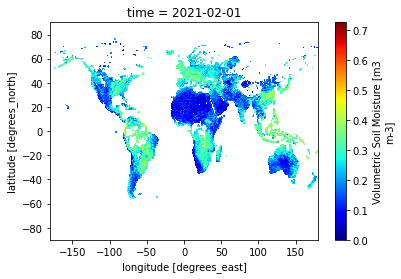

In [8]:
dset['sm'].plot(cmap='jet')


In [10]:
dset['sm'].to_series()

time        lat      lon     
2021-02-01   89.875  -179.875   NaN
                     -179.625   NaN
                     -179.375   NaN
                     -179.125   NaN
                     -178.875   NaN
                                 ..
            -89.875   178.875   NaN
                      179.125   NaN
                      179.375   NaN
                      179.625   NaN
                      179.875   NaN
Name: sm, Length: 1036800, dtype: float32

In [4]:
dset.attrs

{'title': 'C3S Surface Soil Moisture merged COMBINED Product',
 'institution': 'EODC (AUT); TU Wien (AUT); VanderSat B.V. (NL)',
 'contact': 'C3S_SM_Science@eodc.eu',
 'source': 'WARP 5.5R1.1/AMI-WS/ERS12 Level 2 Soil Moisture; WARP 5.4R1.0/AMI-WS/ERS2 Level 2 Soil Moisture; ASCSMR02/ASCAT/MetOp-A SSM Swath Grid 12.5 km sampling; ASCSMR02/ASCAT/MetOp-B SSM Swath Grid 12.5 km sampling; LPRMv05/SMMR/Nimbus 7 L3 Surface Soil Moisture, Ancillary Params, and quality flags; LPRMv05/SSMI/F08, F11, F13 DMSP L3 Surface Soil Moisture, Ancillary Params, and quality flags; LPRMv05/TMI/TRMM L2 Surface Soil Moisture, Ancillary Params, and QC; LPRMv06/AMSR-E/Aqua L2B Surface Soil Moisture, Ancillary Params, and QC; LPRMv05/WINDSAT/CORIOLIS L2 Surface Soil Moisture, Ancillary Params, and QC; LPRMv06/AMSR2/GCOM-W1 L3 Surface Soil Moisture, Ancillary Params; LPRMv06/SMOS/MIRAS L3 Surface Soil Moisture, CATDS Level 3 Brightness Temperatures (L3TB) version 300 RE03 & RE04;',
 'platform': 'Nimbus 7, DMSP, 

In [5]:
dset.data_vars

Data variables:
    nobs        (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sensor      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    freqbandID  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sm          (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [6]:
dset['sm']

<xarray.DataArray 'sm' (time: 1, lat: 720, lon: 1440)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) datetime64[ns] 2021-02-01
Attributes:
    long_name:        Volumetric Soil Moisture
    units:            m3 m-3
    valid_range:      [0. 1.]
    _CoordinateAxes:  time lat lon

  Created wheel for cdsapi: filename=cdsapi-0.5.1-py2.py3-none-any.whl size=11688 sha256=9fdc6593e49f3f0666b9c4b10174b8405ce734651061588711bdd137ff76f79e
  Stored in directory: /home/jovyan/.cache/pip/wheels/5b/a2/af/7a52b8437e534f0b5f1b71232dd9534920579a142d9a191a63
Successfully built cdsapi


url: https://cds.climate.copernicus.eu/api/v2
key: 80380:4b060692-2f02-446c-8c48-486987c39885
verify: 0


In [7]:
!unzip -l download.zip

Archive:  download.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
   611887  2020-11-18 14:33   C3S-SOILMOISTURE-L3S-SSMV-COMBINED-DEKADAL-20200201000000-ICDR-v201912.0.0.nc
   705256  2020-11-18 14:29   C3S-SOILMOISTURE-L3S-SSMS-ACTIVE-DEKADAL-20200401000000-ICDR-v201912.0.0.nc
   621325  2020-11-18 14:29   C3S-SOILMOISTURE-L3S-SSMS-ACTIVE-DEKADAL-20200301000000-ICDR-v201912.0.0.nc
   607130  2020-11-18 14:33   C3S-SOILMOISTURE-L3S-SSMV-COMBINED-DEKADAL-20200121000000-ICDR-v201912.0.0.nc
   717500  2020-11-18 14:29   C3S-SOILMOISTURE-L3S-SSMS-ACTIVE-DEKADAL-20201101000000-ICDR-v201912.0.0.nc
   809551  2020-11-18 14:30   C3S-SOILMOISTURE-L3S-SSMV-PASSIVE-DEKADAL-20200911000000-ICDR-v201912.0.0.nc
   537272  2021-01-29 19:33   C3S-SOILMOISTURE-L3S-SSMV-PASSIVE-DEKADAL-20210101000000-ICDR-v201912.0.0.nc
   811187  2020-11-18 14:33   C3S-SOILMOISTURE-L3S-SSMV-COMBINED-DEKADAL-20200421000000-ICDR-v201912.0.0.nc
   815939  2020-11-18 14:30   C3S-SOILMOISTURE-L3S-